![SAR, InSAR, PolSAR, and banner](https://opensarlab-docs.asf.alaska.edu/opensarlab-notebook-assets/notebook_images/blackboard-banner.png)

# Subset Data Stack

### Alex Lewandowski; University of Alaska Fairbanks

<img src="https://opensarlab-docs.asf.alaska.edu/opensarlab-notebook-assets/notebook_images/UAFLogo_A_647.png" width="170" align="right" />

This notebook crops a directory of tiffs to a subset area of interest.
It notebook assumes that users have created a directory of geotiffs using the `Prepare_Data_Stack_HyP3` notebook. 

Subset the data with any of the following methods:

1. Select a rectangular area of interest on an interactive plot
1. Use Well-Known Text (WKT)
1. Upload a shapefile

<!-- <img style="padding: 7px" src="NotebookAddons/UAFLogo_A_647.png" width="170" align="right"/></font> -->


---

<font face="Calibri" size="5" color="darkred"> <b>Important Note about JupyterHub</b> </font>

**Your JupyterHub server will automatically shutdown when left idle for more than 1 hour. Your notebooks will not be lost but you will have to restart their kernels and re-run them from the beginning. You will not be able to seamlessly continue running a partially run notebook.**


In [1]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

URLWidget()

In [2]:
from IPython.display import Markdown
from IPython.display import display

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX
if env[0] == '':
    env[0] = 'Python 3 (base)'
if env[0] != '/home/jovyan/.local/envs/rtc_analysis':
    display(Markdown(f'<text style=color:red><strong>WARNING:</strong></text>'))
    display(Markdown(f'<text style=color:red>This notebook should be run using the "rtc_analysis" conda environment.</text>'))
    display(Markdown(f'<text style=color:red>It is currently using the "{env[0].split("/")[-1]}" environment.</text>'))
    display(Markdown(f'<text style=color:red>Select the "rtc_analysis" from the "Change Kernel" submenu of the "Kernel" menu.</text>'))
    display(Markdown(f'<text style=color:red>If the "rtc_analysis" environment is not present, use <a href="{notebookUrl.split("/user")[0]}/user/{user[0]}/notebooks/conda_environments/Create_OSL_Conda_Environments.ipynb"> Create_OSL_Conda_Environments.ipynb </a> to create it.</text>'))
    display(Markdown(f'<text style=color:red>Note that you must restart your server after creating a new environment before it is usable by notebooks.</text>'))


--- 
    
## **0. Importing Relevant Python Packages**

In this notebook we will use the following scientific library:

- [GDAL](https://www.gdal.org/) is a software library for reading and writing raster and vector geospatial data formats. It includes a collection of programs tailored for geospatial data processing. Most modern GIS systems (such as ArcGIS or QGIS) use GDAL in the background.

**Import the necesssary libraries and modules:**


In [3]:
%%capture
from pathlib import Path
import json # for loads
import shutil

from ipyfilechooser import FileChooser

from osgeo import gdal
gdal.UseExceptions()
from rasterio.warp import transform_bounds

from IPython.display import Markdown
from IPython.display import display
%matplotlib widget

# import matplotlib.patches as patches
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

import opensarlab_lib as asfn
asfn.jupytertheme_matplotlib_format()


---
**Write functions to gather and print individual tiff paths:**

In [4]:
def get_tiff_paths(paths):
    tiff_paths = list(paths.parent.glob(paths.name))    
    tiff_paths.sort()
    return tiff_paths

def print_tiff_paths(tiff_paths):
    print("Tiff paths:")
    for p in tiff_paths:
        print(f"{p}\n")

**Select the directory holding your tiffs**
- Click the `Select` button
- Navigate to your data directory
- Click the `Select` button
- Confirm that the desired path appears in green text
- Click the `Change` button to alter your selection
- *Note: If you used `Prepare_Data_Stack_Hyp3` notebook to generate directory, tiffs should be in `RTC_GAMMA_tiffs` directory.*

In [5]:
fc = FileChooser(Path.cwd())
display(fc)

FileChooser(path='/home/jovyan/hydrosar', filename='', title='', show_hidden=False, select_desc='Select', chan…

**Determine the path to the analysis directory containing the tiff directory:**

In [8]:
tiff_dir = Path(fc.selected_path)
analysis_dir = tiff_dir.parent
print(f"analysis_dir: {analysis_dir}\n")

paths = tiff_dir/"*.tif*"
tiff_paths = get_tiff_paths(paths)
print_tiff_paths(tiff_paths)

analysis_dir: /home/jovyan/hydrosar/Dataset/bang_NE

Tiff paths:
/home/jovyan/hydrosar/Dataset/bang_NE/RTC_GAMMA__tiffs/S1A_IW_20190108T120439_DVP_RTC30_G_gpufem_8BD9_VH.tif

/home/jovyan/hydrosar/Dataset/bang_NE/RTC_GAMMA__tiffs/S1A_IW_20190108T120439_DVP_RTC30_G_gpufem_8BD9_VV.tif

/home/jovyan/hydrosar/Dataset/bang_NE/RTC_GAMMA__tiffs/S1A_IW_20190120T120439_DVP_RTC30_G_gpufem_97E2_VH.tif

/home/jovyan/hydrosar/Dataset/bang_NE/RTC_GAMMA__tiffs/S1A_IW_20190120T120439_DVP_RTC30_G_gpufem_97E2_VV.tif

/home/jovyan/hydrosar/Dataset/bang_NE/RTC_GAMMA__tiffs/S1A_IW_20190201T120439_DVP_RTC30_G_gpufem_5EF2_VH.tif

/home/jovyan/hydrosar/Dataset/bang_NE/RTC_GAMMA__tiffs/S1A_IW_20190201T120439_DVP_RTC30_G_gpufem_5EF2_VV.tif

/home/jovyan/hydrosar/Dataset/bang_NE/RTC_GAMMA__tiffs/S1A_IW_20190213T120438_DVP_RTC30_G_gpufem_CA11_VH.tif

/home/jovyan/hydrosar/Dataset/bang_NE/RTC_GAMMA__tiffs/S1A_IW_20190213T120438_DVP_RTC30_G_gpufem_CA11_VV.tif

/home/jovyan/hydrosar/Dataset/bang_NE/RTC_GAMMA__tiffs/

**Determine the UTM zone for your images.** 

This assumes you have already reprojected multiple UTM projections to a single predominant projection using the `Prepare_Data_Stack_Hyp3` notebook.

In [9]:
utm = asfn.get_projection(str(tiff_paths[0]))
print(f"UTM Zone: {utm}")

UTM Zone: 32646


**Choose a `.tif` file to generate your shapefile**

In [10]:
try:
    infile = tiff_paths[0]
except:
    raise OSError('Directory that contains your .tif files is empty.')
try:
    suffix = infile.suffix
    if suffix != '.tif':
        raise ValueError(f'File you chose is not a ".tif" file. Pick a valid ".tif" file.')
except:
    raise TypeError(f'{infile} is not a valid path.')

outfile = str(infile.parent/f'subset_{infile.stem}.tif')

---
## **1. Select a Subsetting Method and Create a Directory in Which to Store Subset Data**

**Select a subsetting option**

In [11]:
print("Please choose one of three options:")

option_key = [
    None,
    'Option 1: Draw a rectangle',
    'Option 2: Well-Known Text (WKT)',
    'Option 3: Shapefile'
]

option = asfn.select_parameter([option_key[1], option_key[2] , option_key[3],], '')
display(option)

Please choose one of three options:


RadioButtons(layout=Layout(min_width='800px'), options=('Option 1: Draw a rectangle', 'Option 2: Well-Known Te…

In [12]:
choice = option_key.index(option.value)

**Create a directory in which to store the subset tiffs**

In [14]:
print("Choose a directory name in which to store the subset geotiffs.")
print("Note: this will sit alongside the directory containing your pre-subset geotiffs.")
while True:
    sub_name = input()
    if sub_name == "":
        print("Please enter a valid directory name")
        continue
    else:
        break
        
subset_dir = analysis_dir/f'{sub_name}'

if not subset_dir.exists():
    subset_dir.mkdir()
# elif any(subset_dir.rglob('*.tif*')):
#     raise Exception(f"{subset_dir} already exists and contains tiffs")

Choose a directory name in which to store the subset geotiffs.
Note: this will sit alongside the directory containing your pre-subset geotiffs.


 subset_East


---
## **2. Prepare for Subsetting**

**Determine the maximum and common bounds of the data stack**

In [15]:
max_extents = asfn.get_max_extents(tiff_paths)
xmin, ymin, xmax, ymax = transform_bounds(int(asfn.get_projection(str(tiff_paths[0]))), 3857, *max_extents)
max_extents = [xmin, ymin, xmax, ymax]

common_extents = asfn.get_common_coverage_extents(tiff_paths)
xmin, ymin, xmax, ymax = transform_bounds(int(asfn.get_projection(str(tiff_paths[0]))), 3857, *common_extents)
common_extents = [xmin, ymin, xmax, ymax]

#### **Option 1: Select an AOI from an interactive plot**

**Determine the maximum and common extents of the stack and plot an Area-of_Interest Selector:**

In [16]:
if choice == 1:
    aoi = asfn.AOI_Selector(max_extents, common_extents, figsize=(10, 8))

**Convert the subset corner coordinates from Web-Mercator back to the input data's EPSG:**

In [17]:
if choice == 1:
    try:
        xmin, ymin, xmax, ymax = transform_bounds(3857, 
                                              int(asfn.get_projection(str(tiff_paths[0]))), 
                                              *[aoi.x1, aoi.y1, aoi.x2, aoi.y2])
        ul = [xmin, ymax]
        lr = [xmax, ymin]
        print(f"AOI Corner Coordinates:")
        print(f"upper left corner: {ul}")
        print(f"lower right corner: {lr}")
    except TypeError:
        print('TypeError')
        display(Markdown(f'<text style=color:red>This error may occur if an AOI was not selected.</text>'))
        display(Markdown(f'<text style=color:red>Note that the square tool icon in the AOI selector menu is <b>NOT</b> the selection tool. It is the zoom tool.</text>'))

#### **Option 2: Create a shapefile from WKT**

**Delete existing shape files (`.shp`, `.prj`, `.dbf`, `.shx`)**

In [18]:
if choice == 2:
    print("We will generate a shapefile from your WKT.")
    print("Would you like to delete any existing shape files in your tiff directory?")
    shp_option = asfn.select_parameter(['Yes', 'No',], '')
    display(shp_option)

In [19]:
if choice == 2 and shp_option.value == 'Yes':
    keywords = ['.shp','.dbf','.prj','.shx']
    
    for path in infile.parent.iterdir():
        for k in keywords:
            if path.suffix == k:
                print(f'Removed {path}')
                path.unlink()

**Choose a name for your `.shp` file:**

In [20]:
if choice == 2:
    shp_name = input('Choose a name for the shapefile you will create: ')
    
    # default name if user does not input anything
    if not shp_name:
        shp_name = 'shape'
    
    shp = str(infile.parent/f'{shp_name}.shp')
    
    print(shp)

**Generate shapefile.**

In [21]:
# Let user input WKT (option 2)
if choice == 2:
    from osgeo import ogr
    import shapely.wkt as sWkt
    import geopandas
    
    print("When inputting your WKT:\n"\
         "\t1) You must use a single polygon (e.g. POLYGON((x y, x y, ...)) \n"\
         "\t2) The bounds of the WKT should be within the extents of the data \n"\
         "\t3) The projection of the WKT should match that of the dataset")
    

    correctWktInput = False
    while not correctWktInput:
        wkt = input("Please enter your WKT: ")
        
        try:
            geoShape = sWkt.loads(wkt)
            series = geopandas.GeoSeries([geoShape])
            isNotConnected = series.is_valid[0]
                        
            if not isNotConnected:
                raise('Obsecure shape detected.')
                continue
                
        except:
            print('Error due to an unclosed shape, obsecure shape, or bad input. Try again...')
            continue
            
        correctWktInput = True
                
    outfile = str(infile.parent/f'subset_{infile.stem}.tif')
    epsg = getEPSG(str(infile))

    driver = ogr.GetDriverByName('Esri Shapefile')
    ds = driver.CreateDataSource(shp)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    layer = ds.CreateLayer('', srs, ogr.wkbPolygon)
    defn = layer.GetLayerDefn()

    # Create a new feature (attribute and geometry)
    feat = ogr.Feature(defn)
    
    # Make a geometry from Shapely object
    geom = ogr.CreateGeometryFromWkt(wkt) 
    feat.SetGeometry(geom)
    
    layer.CreateFeature(feat)
    feat = geom = None  # destroy these

    # Save and close everything
    ds = layer = feat = geom = None

#### **Option 3: Upload `.shp`**

If you chose option 3, upload your shapefile (`.shp`, `.prj`, `.shx` and `.dbf` files). Once you uploaded them, select the .shp file using file selector.

**Note**: `.shp`, `.shx`, `.dbf`, and `.prj` files must be in the same directory.

In [22]:
if choice == 3:
    display(Markdown(f'<text style=color:red>WARNING: The uploaded shapefile must have the same projection as the dataset.</text>'))
    print("Select a shapefile (.shp):")
    shpfc = FileChooser(Path.cwd())
    display(shpfc)

<text style=color:red>WARNING: The uploaded shapefile must have the same projection as the dataset.</text>

Select a shapefile (.shp):


FileChooser(path='/home/jovyan/hydrosar', filename='', title='', show_hidden=False, select_desc='Select', chan…

In [23]:
if choice == 3:
    try:
        shp = Path(shpfc.selected)
    except:
        raise TypeError('Please choose the file path before proceeding.')
        
    print(shp)

/home/jovyan/hydrosar/Dataset/bang_NE/shapeFiles/shapeFile-test_2/bangladesh_shapeFile-test_2.shp


In [24]:
# Extract wkt from shapefile:
if choice == 3:
    if shp.suffix == '.shp':
        gInfo = gdal.OpenEx(str(shp))
        layer = gInfo.GetLayer()
        feature = layer.GetFeature(0)
        wkt = feature.GetGeometryRef().ExportToWkt()

#### **Option 2 & 3: Display shapefile (uploaded or created from WKT) in relation to the stack extents**

**Visually confirm that your AOI is located where you expect it**

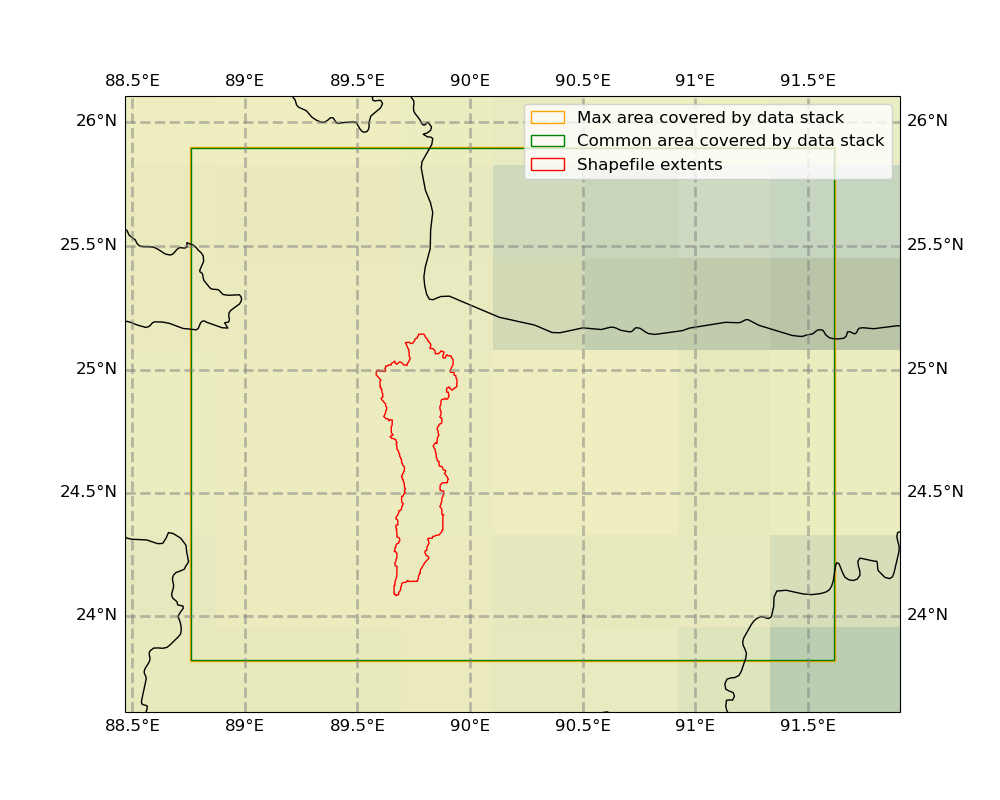

In [25]:
if choice != 1:
    asfn.plot_shape_in_stack(shp, utm, max_extents, common_extents, figsize=(10, 8))

## **3. Subset the Data**

In [26]:
# Create sub-folder within the subset_home folder to contain subsetted tiffs. 

subset_home = Path(subset_dir,'RTC_GAMMA')

if not subset_home.exists():
    subset_home.mkdir()

In [27]:
for i, tiff_path in enumerate(tiff_paths):

    outfile = subset_home/f"{tiff_path.stem}_subset{tiff_path.suffix}"  

    if choice == 1:
        gdal.Translate(destName=str(outfile), srcDS=str(tiff_path), projWin=[ul[0], ul[1], lr[0], lr[1]])
    else: # choice 2 & 3
        gdal.Warp(str(outfile), str(tiff_path), cutlineDSName=str(shp) , cropToCutline=True)

## **4. Clean Up**

**Delete any subset `tifs` that are filled with `NaNs` and contain no data.**

In [28]:
subset_paths = subset_home/f"*.tif*"
tiff_paths = get_tiff_paths(subset_paths)
tiff_paths

[PosixPath('/home/jovyan/hydrosar/Dataset/bang_NE/subset_East/RTC_GAMMA/S1A_IW_20190108T120439_DVP_RTC30_G_gpufem_8BD9_VH_subset.tif'),
 PosixPath('/home/jovyan/hydrosar/Dataset/bang_NE/subset_East/RTC_GAMMA/S1A_IW_20190108T120439_DVP_RTC30_G_gpufem_8BD9_VV_subset.tif'),
 PosixPath('/home/jovyan/hydrosar/Dataset/bang_NE/subset_East/RTC_GAMMA/S1A_IW_20190120T120439_DVP_RTC30_G_gpufem_97E2_VH_subset.tif'),
 PosixPath('/home/jovyan/hydrosar/Dataset/bang_NE/subset_East/RTC_GAMMA/S1A_IW_20190120T120439_DVP_RTC30_G_gpufem_97E2_VV_subset.tif'),
 PosixPath('/home/jovyan/hydrosar/Dataset/bang_NE/subset_East/RTC_GAMMA/S1A_IW_20190201T120439_DVP_RTC30_G_gpufem_5EF2_VH_subset.tif'),
 PosixPath('/home/jovyan/hydrosar/Dataset/bang_NE/subset_East/RTC_GAMMA/S1A_IW_20190201T120439_DVP_RTC30_G_gpufem_5EF2_VV_subset.tif'),
 PosixPath('/home/jovyan/hydrosar/Dataset/bang_NE/subset_East/RTC_GAMMA/S1A_IW_20190213T120438_DVP_RTC30_G_gpufem_CA11_VH_subset.tif'),
 PosixPath('/home/jovyan/hydrosar/Dataset/bang_N

In [29]:
asfn.remove_nan_filled_tifs(tiff_paths)

GeoTiffs Examined: 308
GeoTiffs Removed:  0


**Sometimes, when using gdal translate to subset a stack of images, there will be slight differences in sizes of the resulting images, off by a single pixel in either direction. The following code checks the newly subset stack for this problem, and if found, it re-subsets all the images to the size of the smallest image in the stack.**

In [30]:
# Align geotiffs to an integer resolution value

fnames = list(subset_home.rglob('*.tif*'))
fnames.sort()

resolution = int(gdal.Info(str(fnames[0]), format='json')['geoTransform'][1])
for fname in fnames:
    gdal.Warp(str(fname), str(fname), 
              dstSRS=f'EPSG:{utm}', srcSRS=f'EPSG:{utm}', 
              xRes=resolution, yRes=resolution, targetAlignedPixels=True)

**Decide whether or not to cleanup the original tiffs:**

In [31]:
cleanup = asfn.select_parameter(["Save original tiffs", "Delete original tiffs"], '')
cleanup

RadioButtons(layout=Layout(min_width='800px'), options=('Save original tiffs', 'Delete original tiffs'), value…

In [32]:
if cleanup.value == 'Delete original tiffs':
    shutil.rmtree(tiff_dir)

**Print the path to your subset directory:**

In [33]:
print(subset_dir)

/home/jovyan/hydrosar/Dataset/bang_NE/subset_East


**Relavent notebooks:**

In [34]:
# Run this cell to display links
from IPython.display import display, HTML

current = Path.cwd()
abs_path = [
    Path('/home/jovyan/notebooks/SAR_Training/English/Master/Change_Detection_From_Prepared_Data_Stack.ipynb'),
    Path('/home/jovyan/notebooks/SAR_Training/English/Master/Explore_SAR_Time_Series_From_Prepared_Data_Stack.ipynb'),
    Path('/home/jovyan/notebooks/SAR_Training/English/Master/SARChangeDetectionMethods_From_Prepared_Data_Stack.ipynb'),
    Path('/home/jovyan/notebooks/SAR_Training/English/Master/Time_Series_From_Prepared_Stack.ipynb')
]

details = [
    'Introduce you to the analysis of deep multi-temporal SAR image data stacks.',
    'Introduces you to a some popular change detection methods that can be applied on SAR time series data.',
    'Introduces you to the time series signatures associated with flooding.',
    'Applies Change Point Detection on a deep multi-temporal SAR image data stack acquired by Sentinel-1.'
]


for a in abs_path:
    name = a.stem
    relative_path = a.relative_to(current)
    detail = details.pop()
    link_t = f"<li><a href='{relative_path}'> {name} </a>: {detail} </li>"
    html = HTML(link_t)
    display(html)

ValueError: '/home/jovyan/notebooks/SAR_Training/English/Master/Change_Detection_From_Prepared_Data_Stack.ipynb' is not in the subpath of '/home/jovyan/hydrosar'

*GEOS 657 Microwave Remote Sensing - Version 2.1.0 - June 2023*

*Version Changes:*
- *Use updated AOI_Selector*
- *Display shapefile and WKT polygons on a basemap showing maximum and common coverage extents*
- *general refactoring for clarity*